In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/email-spam-classification-dataset-csv/emails.csv


### Problem Statement

<p>Unsolicited emails can be a great nuisance for several reasons, but two of them standout out of the crowd – storage and security. We only want to keep emails that we care about thereby optimizing our use of the limited storage provided by Email Service providers. Also, we want to avoid getting phishing emails and emails containing spywares or other malicious programs. Tracking spams manually can be difficult, but thanks to machine learning, this process can be automated.</p>

<p>The aim of this project is to develop a machine learning model that would be able to determine if an email is a spam or not. This is a binary classification problem.</p>

#### About the Dataset

The dataset I would be using is the [Email Spam Classification Dataset](https://www.kaggle.com/datasets/balaka18/email-spam-classification-dataset-csv). Its a csv file that contains 5172 rows, each row for each email. There are 3002 columns. The first column indicates Email name. The name has been set with numbers and not recipients' name to protect privacy. The last column has the labels for prediction : 1 for spam, 0 for not spam. The remaining 3000 columns are the 3000 most common words in all the emails, after excluding the non-alphabetical characters/words. For each row, the count of each word(column) in that email(row) is stored in the respective cells.

#### Exploratory Data Analysis

Some of the features of the dataset are stop-words. I will drop them in the preprocessing stage since they don't have any impact on predictions. The only feature that's not an integer is the "Email No." feature. Since they don't also have an impact on predictions, I will drop it as well. The EDA also reveals that the proportion of spam and not spam emails in the dataset are not equal. Therefore, the classification model will not assign equal weights to them.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords

##### Read the data and check the first two rows

In [3]:
# read the data
emails = pd.read_csv(
    '/kaggle/input/email-spam-classification-dataset-csv/emails.csv')

# top 2 rows
emails.head(2)

,Email No.,the,to,ect,and,for,of,a,you,hou,...,connevey,jay,valued,lay,infrastructure,military,allowing,ff,dry,Prediction
0,Email 1,0,0,1,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Email 2,8,13,24,6,6,2,102,1,27,...,0,0,0,0,0,0,0,1,0,0


In [4]:
emails.shape

(5172, 3002)

##### Summary statistics of numeric columns

In [5]:
emails.describe()

,the,to,ect,and,for,of,a,you,hou,in,...,connevey,jay,valued,lay,infrastructure,military,allowing,ff,dry,Prediction
count,5172.000000,5172.000000,5172.000000,5172.000000,5172.000000,5172.000000,5172.000000,5172.000000,5172.000000,5172.000000,...,5172.000000,5172.000000,5172.000000,5172.000000,5172.000000,5172.000000,5172.000000,5172.000000,5172.000000,5172.000000
mean,6.640565,6.188128,5.143852,3.075599,3.124710,2.627030,55.517401,2.466551,2.024362,10.600155,...,0.005027,0.012568,0.010634,0.098028,0.004254,0.006574,0.004060,0.914733,0.006961,0.290023
std,11.745009,9.534576,14.101142,6.045970,4.680522,6.229845,87.574172,4.314444,6.967878,19.281892,...,0.105788,0.199682,0.116693,0.569532,0.096252,0.138908,0.072145,2.780203,0.098086,0.453817
min,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,12.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,3.000000,1.000000,1.000000,2.000000,1.000000,28.000000,1.000000,0.000000,5.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,8.000000,7.000000,4.000000,3.000000,4.000000,2.000000,62.250000,3.000000,1.000000,12.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
max,210.000000,132.000000,344.000000,89.000000,47.000000,77.000000,1898.000000,70.000000,167.000000,223.000000,...,4.000000,7.000000,2.000000,12.000000,3.000000,4.000000,3.000000,114.000000,4.000000,1.000000


##### Check features that are stopwords

In [6]:
# download stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
# get columns that are stopwords

is_a_stopword = emails.columns.isin(stopwords.words('english'))
emails.columns[is_a_stopword]

Index(['the', 'to', 'and', 'for', 'of', 'a', 'you', 'in', 'on', 'is',
       ...
       'nor', 'myself', 'isn', 'haven', 'whom', 'couldn', 'wasn', 'itself',
       'ma', 'aren'],
      dtype='object', length=134)

##### Get columns that are not integers

In [8]:
# select non-integer features
emails.select_dtypes(include=['object', 'bool', 'float', 'category']).head()

,Email No.
0,Email 1
1,Email 2
2,Email 3
3,Email 4
4,Email 5


##### Check for duplicate and missing values

In [9]:
# check for missing values
emails.isna().sum()

Email No.     0
the           0
to            0
ect           0
and           0
             ..
military      0
allowing      0
ff            0
dry           0
Prediction    0
Length: 3002, dtype: int64

In [10]:
# check for duplicates

emails.duplicated().sum()

0

##### Comparing the number of emails that are spam and not spam

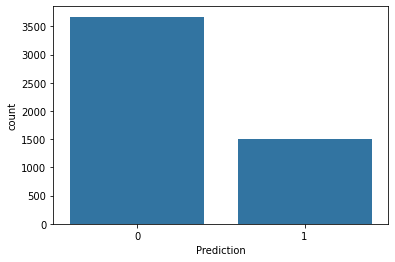

In [11]:
# count plot of the Prediction column

sns.countplot(data=emails, x='Prediction', color=sns.color_palette()[0])

plt.show();

#### Preprocessing

I dropped the "Email No." column and all columns that are stop words. The "Prediction" column is saved in the target variable `y` while the other columns is saved in the features variable `X`. The dataset is also split into $70\%$ train and $30\%$ test sets. I will also standardize the train set.

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [13]:
# remove all stop words

no_stop_words = emails.loc[:, ~is_a_stopword].copy()

no_stop_words.shape

(5172, 2868)

In [14]:
# drop "Email No."

no_stop_words.drop(columns="Email No.", inplace=True)

In [15]:
# split dataset to train and test sets

X = no_stop_words.drop(columns="Prediction")
y = no_stop_words['Prediction']

X_train, X_test, y_train, y_test = \
train_test_split(X, y, train_size=0.7, random_state=7, stratify=y)

print("train set:", X_train.shape, y_train.shape)
print("test set:", X_test.shape, y_test.shape)

train set: (3620, 2866) (3620,)
test set: (1552, 2866) (1552,)


In [16]:
# scale the X_train set

scaler = MinMaxScaler()
scaler.fit(X_train)

X_train_scaled = scaler.fit_transform(X_train)

##### Model Training

Since this is a binary classification problem, I will be training and evaluating a classification model. I chose to use **Logistic Regression** as my base model because it is a simple model that's easy to interpret. I chose **Random Forest** as my secondary model because it is less sensitive to outliers.

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [18]:
# perform logistic regression grid search

params = {'class_weight': ['balanced'],
          'solver': ['lbfgs', 'newton-cg'],
          'penalty': ['l2'],
          'C': [1, 0.1, 0.01, 0.001, 0.0001]}

log_reg = LogisticRegression()

lg_search_grid = GridSearchCV(log_reg, params,
                             scoring = 'precision')
lg_search_grid.fit(X_train_scaled, y_train)
lg_estimator = lg_search_grid.best_estimator_

In [19]:
# best score for logistic regression

lg_search_grid.best_score_

0.8818171877484404

In [20]:
# perform random forest grid search

params = {'class_weight': ['balanced'], 'random_state': [7],
         'n_estimators': [50,100,150,200], 
          'max_depth': [None, 50, 100]}

rf = RandomForestClassifier()

rf_search_grid = RandomizedSearchCV(rf, params, 
                                    scoring='precision',
                                    random_state=10)
rf_search_grid.fit(X_train_scaled, y_train)
rf_estimator = rf_search_grid.best_estimator_

In [21]:
# best precision score for random forest

rf_search_grid.best_score_

0.9398110683109918

##### Model Evaluation

I chose the **precision** metric because we want a model that correctly classifies spam emails with few false positives. We want to reduce cases where an email that's not a spam is incorrectly classified as one by the model.

From the classification report, the Random Forest model out performs the Logistic Regression model – the former has a $64\%$ precision score while the later has a $99\%$ precision score on the test set. The report also shows that the Random Forest model generalizes better compared to the Logistic Regression model since it is not sufferring from overfitting.

In [22]:
from sklearn.metrics import classification_report

In [23]:
# classification report on logistic regression

y_pred_lg = lg_estimator.predict(X_test)

print(classification_report(y_test, y_pred_lg))

              precision    recall  f1-score   support

           0       1.00      0.77      0.87      1102
           1       0.64      0.99      0.78       450

    accuracy                           0.84      1552
   macro avg       0.82      0.88      0.83      1552
weighted avg       0.89      0.84      0.84      1552



/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [24]:
# classification report on random forest

y_pred_rf = rf_estimator.predict(X_test)
print(classification_report(y_test, y_pred_rf))

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


              precision    recall  f1-score   support

           0       0.87      1.00      0.93      1102
           1       0.99      0.65      0.78       450

    accuracy                           0.90      1552
   macro avg       0.93      0.82      0.86      1552
weighted avg       0.91      0.90      0.89      1552

